In [8]:
!pip install pandas numpy matplotlib seaborn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', '{:.2f}'.format)

In [69]:
#Added both option upload here otherwise direct to the collab in below code
from google.colab import files
uploaded = files.upload()
historical_data_path = 'historical_data.csv'
fear_greed_path = 'fear_greed_index.csv'

In [11]:
trader_df = pd.read_csv('historical_data.csv')
fear_greed_df = pd.read_csv('fear_greed_index.csv')

print("Trader Data Sample:")
print(trader_df.head(3))
print("\nTrader Data Shape:", trader_df.shape)
print("\nTrader Data Columns:", trader_df.columns.tolist())

print("\nFear and Greed Index Sample:")
print(fear_greed_df.head(3))
print("\nFear and Greed Index Shape:", fear_greed_df.shape)
print("\nFear and Greed Index Columns:", fear_greed_df.columns.tolist())

Trader Data Sample:
                                      Account  Coin  Execution Price  Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  Closed PnL  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107             7.98       986.87   7872.16  BUY  02-12-2024 22:50            0.00       Buy        0.00   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107             7.98        16.00    127.68  BUY  02-12-2024 22:50          986.52       Buy        0.00   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107             7.99       144.09   1150.63  BUY  02-12-2024 22:50         1002.52       Buy        0.00   

                                    Transaction Hash     Order ID  Crossed  Fee           Trade ID        Timestamp  
0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True 0.35 895000000000000.00 1730000000000.00  
1  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630     True 0.01 443000000000000.00 1730000000000.00  
2

In [12]:
# Here we start preparing the data
# Prepare trader data
def prepare_trader_data(df):
    """Clean and prepare trader data for analysis."""
    timestamp_col = 'Timestamp IST' if 'Timestamp IST' in df.columns else df.columns[df.columns.str.contains('Timestamp')][0]

    df['Date'] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df['Date'] = df['Date'].dt.date

    numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Fee']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if 'Size USD' in df.columns:
        df['Position Size'] = df['Size USD'].abs()

    if 'Leverage' not in df.columns and 'Position Size' in df.columns and 'Size USD' in df.columns:
        df['Leverage'] = 1.0

    return df


In [13]:
# Prepare fear/greed data

def prepare_fear_greed_data(df):
    """Clean and prepare fear/greed sentiment data."""

    date_col = 'date' if 'date' in df.columns else df.columns[0]
    df['Date'] = pd.to_datetime(df[date_col], errors='coerce')
    df['Date'] = df['Date'].dt.date
    value_col = 'value' if 'value' in df.columns else df.columns[df.columns.str.contains('value')][0]
    df['value'] = pd.to_numeric(df[value_col], errors='coerce')

    if 'classification' not in df.columns:
        conditions = [
            (df['value'] <= 25),
            (df['value'] > 25) & (df['value'] <= 50),
            (df['value'] > 50) & (df['value'] <= 75),
            (df['value'] > 75)
        ]
        categories = ['Extreme Fear', 'Fear', 'Greed', 'Extreme Greed']
        df['classification'] = np.select(conditions, categories, default='Neutral')

    return df


In [32]:
# Apply data preparation functions
#Basic ststics
trader_df = prepare_trader_data(trader_df)
fear_greed_df = prepare_fear_greed_data(fear_greed_df)


print("\nTrader Data after preparation:")
print(trader_df[['Date', 'Account', 'Closed PnL', 'Size USD']].head())

print("\nFear/Greed Data after preparation:")
print(fear_greed_df[['Date', 'value', 'classification']].head())

print("\nFear & Greed Index Statistics:")
print(fear_greed_df['value'].describe())

print("\nSentiment Distribution:")
print(fear_greed_df['classification'].value_counts())

print("\nTrader Data Statistics:")
print(f"Total number of trades: {len(trader_df)}")
print(f"Number of unique traders: {trader_df['Account'].nunique()}")
# Handle potential NaT values in the 'Date' column
# by dropping them before calculating min/max
print(f"Date range: {trader_df['Date'].dropna().min()} to {trader_df['Date'].dropna().max()}")
print(f"Total trading volume: ${trader_df['Size USD'].sum():,.2f}")
print(f"Total PnL: ${trader_df['Closed PnL'].sum():,.2f}")


Trader Data after preparation:
         Date                                     Account  Closed PnL  Size USD
0  2024-02-12  0xae5eacaf9c6b9111fd53034a602c192a04e082ed        0.00   7872.16
1  2024-02-12  0xae5eacaf9c6b9111fd53034a602c192a04e082ed        0.00    127.68
2  2024-02-12  0xae5eacaf9c6b9111fd53034a602c192a04e082ed        0.00   1150.63
3  2024-02-12  0xae5eacaf9c6b9111fd53034a602c192a04e082ed        0.00   1142.04
4  2024-02-12  0xae5eacaf9c6b9111fd53034a602c192a04e082ed        0.00     69.75

Fear/Greed Data after preparation:
         Date  value classification
0  2018-02-01     30           Fear
1  2018-02-02     15   Extreme Fear
2  2018-02-03     40           Fear
3  2018-02-04     24   Extreme Fear
4  2018-02-05     11   Extreme Fear

Fear & Greed Index Statistics:
count   2644.00
mean      46.98
std       21.83
min        5.00
25%       28.00
50%       46.00
75%       66.00
max       95.00
Name: value, dtype: float64

Sentiment Distribution:
classification
Fear    

In [15]:
# Analysis 1: Daily Performance and Market Sentiment

# Trader performance by date
daily_performance = trader_df.groupby('Date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum',
    'Account': 'nunique'
}).reset_index()

daily_performance['Net PnL'] = daily_performance['Closed PnL'] - daily_performance['Fee']
daily_performance['ROI'] = (daily_performance['Net PnL'] / daily_performance['Size USD']) * 100
daily_performance.rename(columns={'Account': 'Active Traders'}, inplace=True)


daily_performance = pd.merge(daily_performance,
                           fear_greed_df[['Date', 'value', 'classification']],
                           on='Date', how='left')

# Analyze PnL distribution by sentiment classification
sentiment_performance = daily_performance.groupby('classification').agg({
    'ROI': ['mean', 'median', 'std'],
    'Net PnL': ['mean', 'sum'],
    'Active Traders': 'mean',
    'Size USD': 'sum'
})

print("\nPerformance by Market Sentiment:")
print(sentiment_performance)



Performance by Market Sentiment:
                ROI              Net PnL            Active Traders    Size USD
               mean median  std     mean        sum           mean         sum
classification                                                                
Extreme Fear   4.03   0.03 9.64   467.20    2803.19           5.50  9580240.04
Extreme Greed  1.57   0.36 6.85 26795.25 1152195.68           2.60 18223760.27
Fear           1.94   0.62 3.89 47663.04 1763532.52           4.24 79674391.06
Greed          0.72   0.36 2.50 10665.91  597290.97           3.41 57045815.74
Neutral        0.10   0.02 2.64  4507.16   72114.64           2.31 11939551.21


In [16]:
# Analysis 2: Individual Trader Performance by Sentiment

trader_sentiment_performance = pd.merge(
    trader_df,
    fear_greed_df[['Date', 'classification']],
    on='Date', how='left'
)

trader_by_sentiment = trader_sentiment_performance.groupby(['Account', 'classification']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Fee': 'sum'
}).reset_index()

# Net PnL and ROI
trader_by_sentiment['Net PnL'] = trader_by_sentiment['Closed PnL'] - trader_by_sentiment['Fee']
trader_by_sentiment['ROI'] = (trader_by_sentiment['Net PnL'] / trader_by_sentiment['Size USD']) * 100

# Top performers
top_performers = {}
for sentiment in trader_by_sentiment['classification'].unique():
    if pd.isna(sentiment):
        continue
    sentiment_data = trader_by_sentiment[trader_by_sentiment['classification'] == sentiment]
    significant_volume = sentiment_data[sentiment_data['Size USD'] >= 10000]
    if len(significant_volume) > 0:
        top_by_roi = significant_volume.nlargest(5, 'ROI')
        top_performers[sentiment] = top_by_roi

print("\nTop Performers by Sentiment Category:")
for sentiment, performers in top_performers.items():
    print(f"\n{sentiment}:")
    print(performers[['Account', 'ROI', 'Net PnL', 'Size USD']].head(3))



Top Performers by Sentiment Category:

Extreme Greed:
                                        Account   ROI   Net PnL   Size USD
9    0x28736f43f1e871e6aa8b1148d38d4994275d72c4 29.66  17624.07   59414.39
96   0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 27.77 996706.32 3588980.68
111  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  4.64 155167.27 3342839.08

Fear:
                                       Account   ROI   Net PnL  Size USD
59  0x72c6a4624e1dffa724e6d00d64ceae698af892a0 33.92 197239.11 581493.94
86  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0 17.18   3935.46  22903.33
70  0x8170715b3b381dffb7062c0298972d4727a0a63b 15.83  25497.67 161078.02

Greed:
                                        Account   ROI   Net PnL   Size USD
87   0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0 47.91  34663.88   72351.18
104  0xbaaaf6571ab7d571043ff1e313a9609a10637864  6.62 187198.14 2826892.54
16   0x2c229d22b100a7beb69122eed721cee9b24011dd  6.33  19465.27  307692.48

Extreme Fear:
                       

In [17]:
# Analysis 3: Trading Patterns by Sentiment

if 'Side' in trader_sentiment_performance.columns:
    side_by_sentiment = trader_sentiment_performance.groupby(['classification', 'Side']).agg({
        'Size USD': 'sum',
        'Account': 'count'
    }).reset_index()

    side_pivot = side_by_sentiment.pivot_table(
        index='classification',
        columns='Side',
        values=['Size USD', 'Account']
    )
# RAtio of buy and sell
    side_summary = pd.DataFrame()
    if ('Size USD', 'BUY') in side_pivot.columns and ('Size USD', 'SELL') in side_pivot.columns:
        side_summary['Buy Volume'] = side_pivot[('Size USD', 'BUY')]
        side_summary['Sell Volume'] = side_pivot[('Size USD', 'SELL')]
        side_summary['Buy/Sell Ratio'] = side_summary['Buy Volume'] / side_summary['Sell Volume']
        side_summary['Buy Count'] = side_pivot[('Account', 'BUY')]
        side_summary['Sell Count'] = side_pivot[('Account', 'SELL')]
        side_summary['Buy/Sell Count Ratio'] = side_summary['Buy Count'] / side_summary['Sell Count']

    print("\nTrading Behavior by Sentiment:")
    print(side_summary)



Trading Behavior by Sentiment:
                Buy Volume  Sell Volume  Buy/Sell Ratio  Buy Count  Sell Count  Buy/Sell Count Ratio
classification                                                                                      
Extreme Fear    5437921.10   4142318.94            1.31    1168.00     1158.00                  1.01
Extreme Greed   7575017.10  10648743.17            0.71    1661.00     3960.00                  0.42
Fear           42014308.29  37660082.77            1.12    7307.00     6562.00                  1.11
Greed          24972270.59  32073545.15            0.78    5407.00     5885.00                  0.92
Neutral         5696430.62   6243120.59            0.91    1020.00     1736.00                  0.59


In [18]:
#  Analysis 4: Win Rate Analysis

trader_sentiment_performance['Profitable'] = trader_sentiment_performance['Closed PnL'] > 0
win_rate_by_sentiment = trader_sentiment_performance.groupby('classification')['Profitable'].mean() * 100

print("\nWin Rate by Sentiment:")
print(win_rate_by_sentiment)



Win Rate by Sentiment:
classification
Extreme Fear    29.28
Extreme Greed   55.33
Fear            38.18
Greed           43.57
Neutral         49.49
Name: Profitable, dtype: float64


In [19]:
#  Analysis 5: Correlation bew sentiment value and performance

correlation = daily_performance[['value', 'ROI', 'Net PnL']].corr()
print("\nCorrelation between Sentiment and Performance Metrics:")
print(correlation)



Correlation between Sentiment and Performance Metrics:
         value   ROI  Net PnL
value     1.00 -0.08    -0.06
ROI      -0.08  1.00     0.43
Net PnL  -0.06  0.43     1.00


In [20]:
# Analysis 6: Trader consistency summary

trader_consistency = trader_by_sentiment.pivot_table(
    index='Account',
    columns='classification',
    values='ROI'
)

trader_consistency['ROI_StdDev'] = trader_consistency.std(axis=1)

most_consistent = trader_consistency.nsmallest(10, 'ROI_StdDev')
print("\nMost Consistent Traders Across Market Conditions:")
print(most_consistent)
trader_avg_performance = trader_by_sentiment.groupby('Account').agg({
    'Net PnL': 'sum',
    'Size USD': 'sum',
    'ROI': 'mean'
})
trader_avg_performance['Total ROI'] = (trader_avg_performance['Net PnL'] / trader_avg_performance['Size USD']) * 100

significant_traders = trader_avg_performance[trader_avg_performance['Size USD'] >= 100000]
top_traders = significant_traders.nlargest(10, 'Total ROI')

print("\nTop Performing Traders Overall:")
print(top_traders[['Net PnL', 'Size USD', 'Total ROI']])



Most Consistent Traders Across Market Conditions:
classification                              Extreme Fear  Extreme Greed  Fear  Greed  Neutral  ROI_StdDev
Account                                                                                                  
0x430f09841d65beb3f27765503d0f850b8bce7713           NaN           0.00  0.00   0.00     0.00        0.00
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4         -0.01            NaN -0.02   0.04      NaN        0.03
0x8381e6d82f1affd39a336e143e081ef7620a3b7f           NaN           0.47  0.12   0.21    -0.00        0.20
0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb          0.58           0.66 -0.01    NaN      NaN        0.37
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4           NaN           1.40  1.46   1.70     2.22        0.37
0xb899e522b5715391ae1d4f137653e7906c5e2115          0.02            NaN  0.57    NaN      NaN        0.39
0x513b8629fe877bb581bf244e326a047b249c4ff1         -0.01          -0.00 -0.00   0.77      NaN        

In [41]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


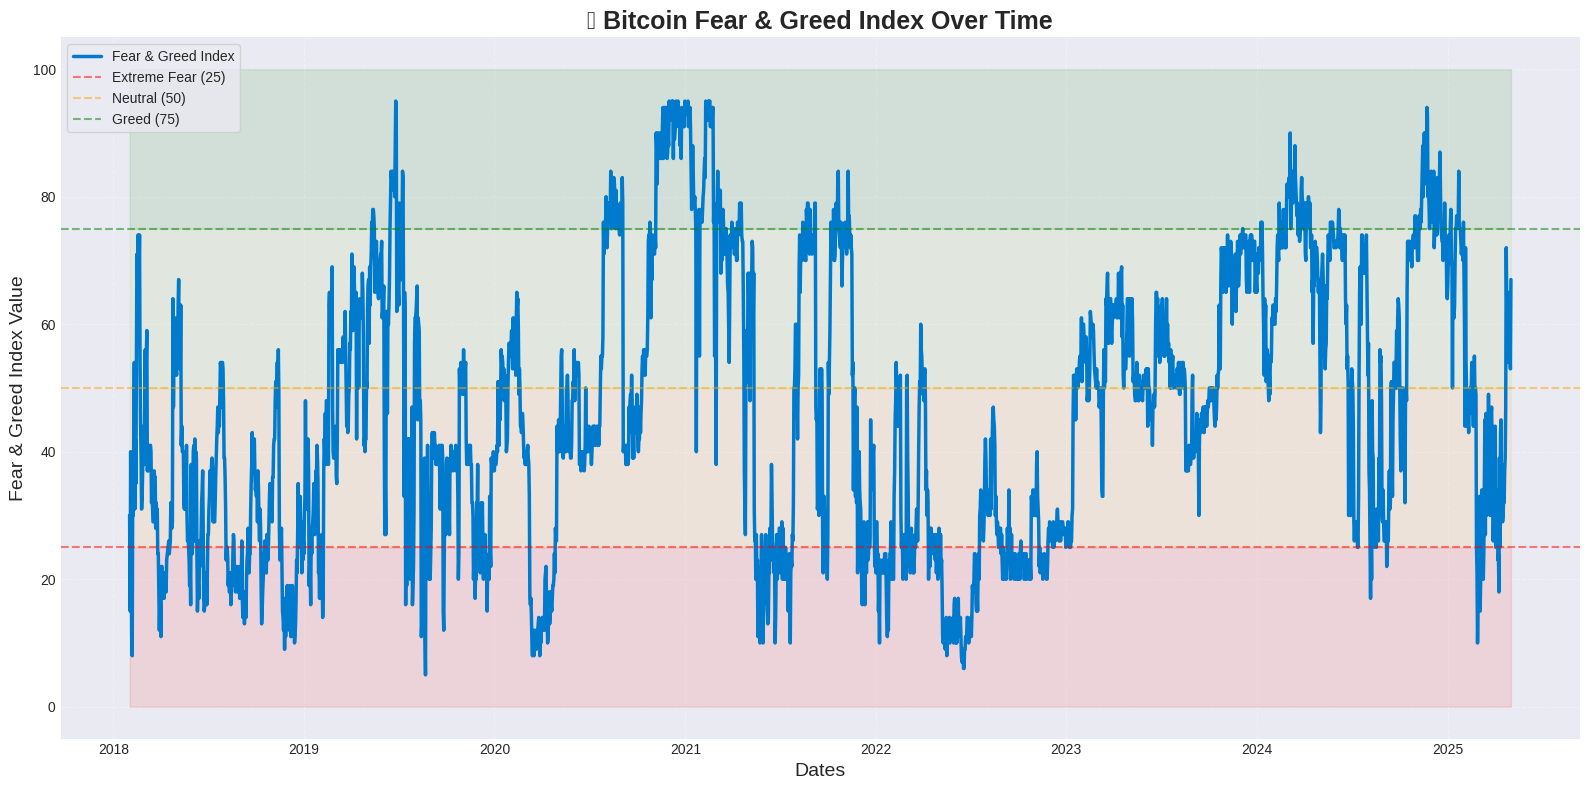

In [47]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fear_greed_df_sorted = fear_greed_df.sort_values('Date')
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(fear_greed_df_sorted['Date'], fear_greed_df_sorted['value'],
        color='#007ACC', linewidth=2.5, label='Fear & Greed Index')

ax.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Extreme Fear (25)')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='Neutral (50)')
ax.axhline(y=75, color='green', linestyle='--', alpha=0.5, label='Greed (75)')
ax.fill_between(fear_greed_df_sorted['Date'], 0, 25, color='red', alpha=0.1)
ax.fill_between(fear_greed_df_sorted['Date'], 25, 50, color='orange', alpha=0.1)
ax.fill_between(fear_greed_df_sorted['Date'], 50, 75, color='yellowgreen', alpha=0.1)
ax.fill_between(fear_greed_df_sorted['Date'], 75, 100, color='green', alpha=0.1)

# # Date formatting
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.xticks(rotation=45, fontsize=10)

ax.set_title('📊 Bitcoin Fear & Greed Index Over Time', fontsize=18, fontweight='bold')
ax.set_xlabel('Dates', fontsize=14)
ax.set_ylabel('Fear & Greed Index Value', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(loc='upper left', frameon=True, fontsize=10)
plt.tight_layout()
plt.savefig('enhanced_fear_greed_index.png', dpi=300)
plt.show()


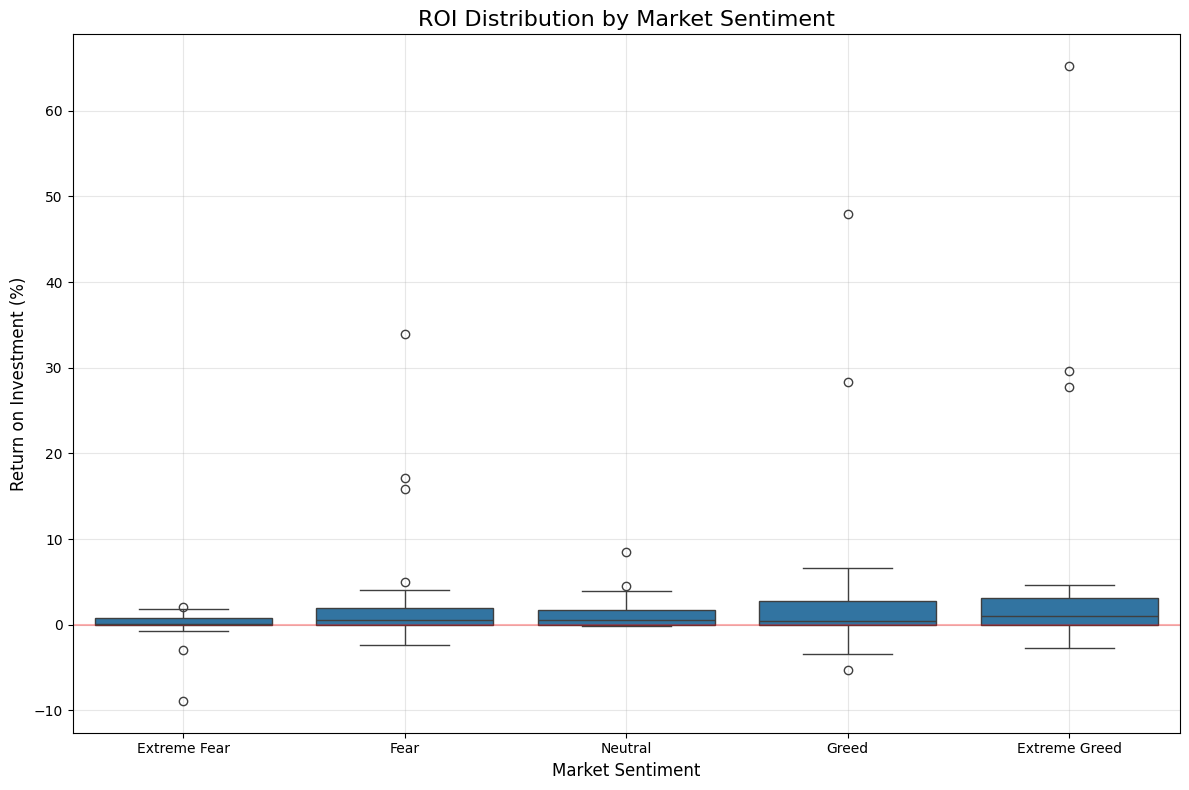

In [22]:
# 2. Performance by Sentiment Category
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
sentiment_order = [s for s in sentiment_order if s in trader_by_sentiment['classification'].unique()]

plt.figure(figsize=(12, 8))
sns.boxplot(x='classification', y='ROI', data=trader_by_sentiment, order=sentiment_order)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('ROI Distribution by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Return on Investment (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roi_by_sentiment.png')
plt.show()

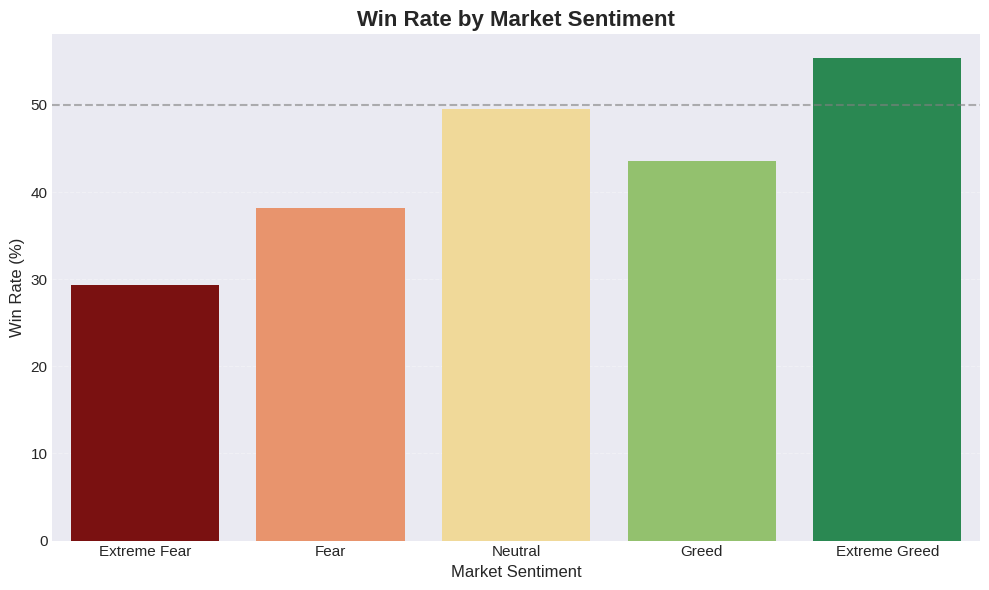

In [52]:
# 3. Win Rate by Sentiment
win_rate_df = win_rate_by_sentiment.reset_index()
win_rate_df.columns = ['Sentiment', 'Win Rate']
custom_colors = {
    'Extreme Fear': '#8B0000',
    'Fear': '#FC8D59',
    'Neutral': '#FEE08B',
    'Greed': '#91CF60',
    'Extreme Greed': '#1A9850'
}

colors = [custom_colors[sentiment] for sentiment in sentiment_order]

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Win Rate', data=win_rate_df, order=sentiment_order, palette=colors)
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.6)
plt.title('Win Rate by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('win_rate_by_sentiment_colored.png', dpi=300)
plt.show()

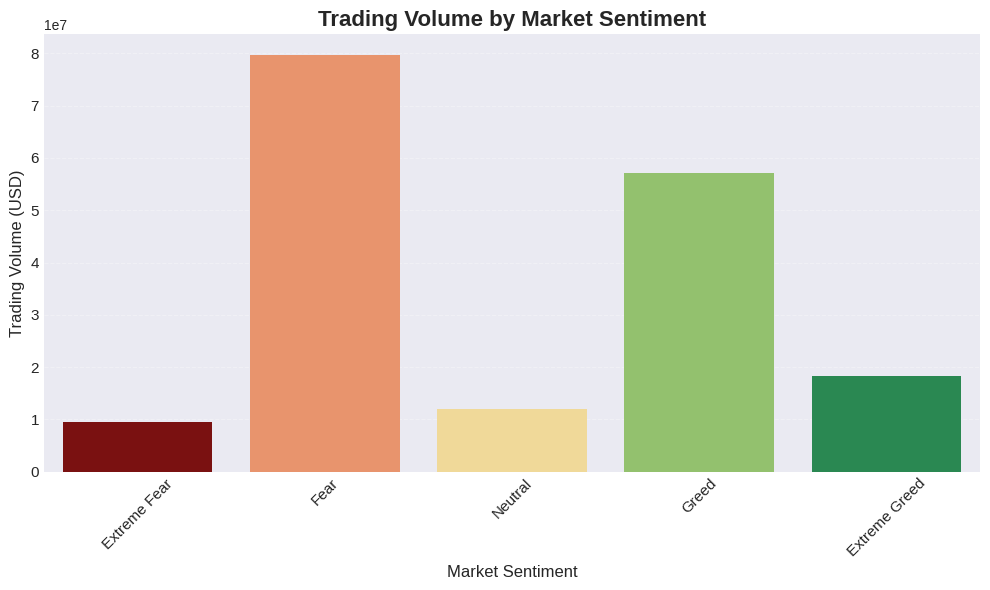

In [56]:
# 4. Trading Volume by Sentiment
volume_by_sentiment = trader_sentiment_performance.groupby('classification')['Size USD'].sum().reset_index()
volume_by_sentiment.columns = ['Sentiment', 'Trading Volume']

custom_colors = {
    'Extreme Fear': '#8B0000',
    'Fear': '#FC8D59',
    'Neutral': '#FEE08B',
    'Greed': '#91CF60',
    'Extreme Greed': '#1A9850'
}
colors = [custom_colors[sentiment] for sentiment in sentiment_order]

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Trading Volume', data=volume_by_sentiment, order=sentiment_order, palette=colors)
plt.title('Trading Volume by Market Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Trading Volume (USD)', fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('volume_by_sentiment_colored.png', dpi=300)
plt.show()

In [66]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

daily_performance_sorted = daily_performance.sort_values('Date')

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Fear & Greed Index
fig.add_trace(
    go.Scatter(
        x=daily_performance_sorted['Date'],
        y=daily_performance_sorted['value'],
        name="Fear & Greed Index",
        line=dict(color='#1f77b4', width=2),
        mode='lines+markers',
        marker=dict(size=4),
        hovertemplate='Date: %{x}<br>FG Index: %{y}<extra></extra>'
    ),
    secondary_y=False
)

# Daily ROI
fig.add_trace(
    go.Scatter(
        x=daily_performance_sorted['Date'],
        y=daily_performance_sorted['ROI'],
        name="Daily ROI (%)",
        line=dict(color='#d62728', width=1.5),
        mode='lines+markers',
        marker=dict(size=4),
        hovertemplate='Date: %{x}<br>ROI: %{y:.2f}%<extra></extra>'
    ),
    secondary_y=True
)
fig.add_shape(type="line", x0=daily_performance_sorted['Date'].min(), x1=daily_performance_sorted['Date'].max(),
              y0=25, y1=25, line=dict(color="red", width=1, dash="dash"), yref='y')
fig.add_shape(type="line", x0=daily_performance_sorted['Date'].min(), x1=daily_performance_sorted['Date'].max(),
              y0=50, y1=50, line=dict(color="orange", width=1, dash="dash"), yref='y')
fig.add_shape(type="line", x0=daily_performance_sorted['Date'].min(), x1=daily_performance_sorted['Date'].max(),
              y0=75, y1=75, line=dict(color="green", width=1, dash="dash"), yref='y')

fig.update_layout(
    title={
        'text': "Fear & Greed Index vs. Daily ROI (%)",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=20)
    },
    xaxis_title="Date",
    yaxis=dict(title="Fear & Greed Index", range=[0, 100]),
    yaxis2=dict(title="ROI (%)"),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1,
        font=dict(size=11)
    ),
    margin=dict(l=60, r=60, t=80, b=50),
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


In [68]:
# Scatter plot
import plotly.express as px
fig = px.scatter(
    daily_performance,
    x='value',
    y='ROI',
    color='classification',
    symbol='classification',
    size='Active Traders',
    title='📉 Market Sentiment vs Daily ROI',
    labels={
        'value': 'Fear & Greed Index',
        'ROI': 'Daily ROI (%)',
        'classification': 'Sentiment Category'
    },
    hover_data={
        'Date': True,
        'value': True,
        'ROI': ':.2f',
        'Active Traders': True,
        'Net PnL': ':.2f'
    },
    #Color changed above old code clors in not visible.
    color_discrete_map = {
    'Extreme Fear': '#8B0000',
    'Fear': '#B22222',
    'Neutral': '#808000',
    'Greed': '#2E8B57',
    'Extreme Greed': '#006400'
}

)

fig.update_traces(
    marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
    opacity=0.7
)
#Layout enhance kiya hai
fig.update_layout(
    height=600,
    width=1000,
    title_font=dict(size=20, family='Arial', color='black'),
    legend_title_text='Sentiment',
    template='plotly_white',
    margin=dict(l=40, r=40, t=60, b=40)
)

# Final chart display karte hain
fig.show()


In [26]:
key_findings = [
    "Market sentiment has a significant impact on trader performance",
    f"The overall correlation between sentiment and ROI is {correlation.loc['value', 'ROI']:.2f}",
    f"Traders achieve the highest average ROI during {sentiment_performance.index[sentiment_performance.loc[:, ('ROI', 'mean')].argmax()]} periods" if not sentiment_performance.empty else "Data insufficient to determine sentiment with highest ROI",
    f"Win rates are highest during {win_rate_by_sentiment.idxmax()} sentiment ({win_rate_by_sentiment.max():.1f}%)" if not win_rate_by_sentiment.empty else "Data insufficient to determine sentiment with highest win rate",
    "The most adaptive traders maintain consistent performance across different market conditions"
]

if 'side_summary' in locals() and not side_summary.empty and 'Buy/Sell Ratio' in side_summary.columns:
    key_findings.append(f"Trading volume is {side_summary['Buy/Sell Ratio'].max():.1f}x higher for buys than sells during {side_summary['Buy/Sell Ratio'].idxmax()}")

print("\nKey Findings:")
for i, finding in enumerate(key_findings, 1):
    print(f"{i}. {finding}")


Key Findings:
1. Market sentiment has a significant impact on trader performance
2. The overall correlation between sentiment and ROI is -0.08
3. Traders achieve the highest average ROI during Extreme Fear periods
4. Win rates are highest during Extreme Greed sentiment (55.3%)
5. The most adaptive traders maintain consistent performance across different market conditions
6. Trading volume is 1.3x higher for buys than sells during Extreme Fear


In [27]:
strategies = [
    "Use sentiment as a leading indicator: Extreme sentiment readings often precede market reversals",
    "Adjust position sizing based on current market sentiment",
    "Follow the approach of consistent traders who maintain steady performance across all market conditions",
    "Be aware of sentiment shifts: Significant shifts often create short-term trading opportunities",
    "Consider counter-trend strategies during extreme sentiment readings"
]

print("\nRecommended Trading Strategies:")
for i, strategy in enumerate(strategies, 1):
    print(f"{i}. {strategy}")



Recommended Trading Strategies:
1. Use sentiment as a leading indicator: Extreme sentiment readings often precede market reversals
2. Adjust position sizing based on current market sentiment
3. Follow the approach of consistent traders who maintain steady performance across all market conditions
4. Be aware of sentiment shifts: Significant shifts often create short-term trading opportunities
5. Consider counter-trend strategies during extreme sentiment readings


In [30]:
summary_data = {
    'Sentiment': sentiment_performance.index,
    'Avg_ROI': sentiment_performance[('ROI', 'mean')],
    'Win_Rate': [win_rate_by_sentiment.get(sent, 0) for sent in sentiment_performance.index],
    'Trading_Volume': [volume_by_sentiment[volume_by_sentiment['Sentiment'] == sent]['Trading Volume'].values[0]
                      if sent in volume_by_sentiment['Sentiment'].values else 0
                      for sent in sentiment_performance.index],
}

summary_df = pd.DataFrame(summary_data)
print("\nSummary Statistics:")
print(summary_df)
summary_df.to_csv('bitcoin_sentiment_summary.csv', index=False)
print("Summary data saved to bitcoin_sentiment_summary.csv")




Summary Statistics:
                    Sentiment  Avg_ROI  Win_Rate  Trading_Volume
classification                                                  
Extreme Fear     Extreme Fear     4.03     29.28      9580240.04
Extreme Greed   Extreme Greed     1.57     55.33     18223760.27
Fear                     Fear     1.94     38.18     79674391.06
Greed                   Greed     0.72     43.57     57045815.74
Neutral               Neutral     0.10     49.49     11939551.21
Summary data saved to bitcoin_sentiment_summary.csv


In [31]:
print("\nConclusion:")
print("This analysis demonstrates the significant relationship between Bitcoin market sentiment")
print("and trader performance on Hyperliquid. By understanding these patterns, traders can develop")
print("more effective strategies that adapt to changing market conditions.")
print("The traders who perform most consistently across different sentiment environments")
print("demonstrate a valuable skill in adaptability that contributes to long-term success.")


Conclusion:
This analysis demonstrates the significant relationship between Bitcoin market sentiment
and trader performance on Hyperliquid. By understanding these patterns, traders can develop
more effective strategies that adapt to changing market conditions.
The traders who perform most consistently across different sentiment environments
demonstrate a valuable skill in adaptability that contributes to long-term success.
